In [1]:
import pandas as pd
import re

filename = '../../data/data.dat'

with open(filename, 'r', encoding='utf-8') as f:
    content = f.read()

def extract_param_block(param_name):
    """
    Extrae las líneas del bloque 'param <name> := ... ;'
    """
    pattern = rf'param\s+{re.escape(param_name)}\s*:=\s*(.*?)\s*;'
    match = re.search(pattern, content, re.DOTALL)
    if not match:
        return []
    lines = match.group(1).strip().splitlines()
    return [line.strip() for line in lines if line.strip()]

# Demandas h_i
h_lines = extract_param_block('h')
h_data = [tuple(map(float, line.split())) for line in h_lines]
df_h = pd.DataFrame(h_data, columns=['nodo', 'h'])

# Costos f_j
f_lines = extract_param_block('f')
f_data = [tuple(map(float, line.split())) for line in f_lines]
df_f = pd.DataFrame(f_data, columns=['nodo', 'f'])

# Matriz de distancias d[i,j]
d_lines = extract_param_block('d')
d_data = [tuple(map(float, line.split())) for line in d_lines]
df_d = pd.DataFrame(d_data, columns=['origen', 'destino', 'd'])

In [2]:
df_h

,nodo,h
0,1.0,1100.0
1,2.0,1200.0
2,3.0,550.0
3,4.0,820.0
4,5.0,880.0


In [3]:
df_f

,nodo,f
0,1.0,310.0
1,2.0,250.0
2,3.0,80.0
3,4.0,120.0
4,5.0,260.0


In [4]:
df_d

,origen,destino,d
0,1.0,1.0,0.0
1,1.0,2.0,4.2
2,1.0,3.0,2.7
3,1.0,4.0,2.3
4,1.0,5.0,2.2
5,2.0,1.0,4.2
6,2.0,2.0,0.0
7,2.0,3.0,1.9
8,2.0,4.0,3.7
9,2.0,5.0,6.4


In [5]:
import pandas as pd

with open('../../data/data.dat','r', encoding='utf-8') as f:
    txt = f.read()

u = float(re.search(r'param\s+u\s*:=\s*([\d\.]+)', txt).group(1))

d_block = re.search(r'param\s+d\s*:=\s*(.*?)\s*;', txt, re.DOTALL).group(1).strip().splitlines()

distances = [(int(i), int(j), float(v)) for i,j,v in (line.split() for line in d_block)]

df_d = pd.DataFrame(distances, columns=['origen','destino','d'])

df_d['c'] = df_d['d'] * u

cost_matrix = df_d.pivot(index='origen', columns='destino', values='c')

cost_matrix = cost_matrix.fillna(float('inf'))

print(cost_matrix)

destino     1     2     3     4     5
origen                               
1        0.00  2.10  1.35  1.15  1.10
2        2.10  0.00  0.95  1.85  3.20
3        1.35  0.95  0.00  1.30  2.45
4        1.15  1.85  1.30  0.00  2.80
5        1.10  3.20  2.45  2.80  0.00


In [6]:
import numpy as np
import random
from typing import List, Tuple, Set
import time

nodes = sorted(set(df_h['nodo'].astype(int)) | set(df_f['nodo'].astype(int)))
demands = dict(zip(df_h['nodo'].astype(int), df_h['h']))
fixed_costs = dict(zip(df_f['nodo'].astype(int), df_f['f']))

transport_costs = cost_matrix.fillna(float('inf')).values
n_nodes = len(nodes)

def calculate_total_cost(solution: List[int]) -> float:
    """Calcula el costo total de una solución"""
    if not solution:
        return float('inf')
    fixed_cost = sum(fixed_costs[facility] for facility in solution)
    
    transport_cost = 0
    for client in nodes:
        if client in demands:
            min_cost = min(transport_costs[client-1][facility-1] for facility in solution)
            transport_cost += demands[client] * min_cost
    
    return fixed_cost + transport_cost

def greedy_algorithm() -> Tuple[List[int], float, int]:
    solution = []
    remaining_facilities = set(nodes)
    iterations = 0
    
    while remaining_facilities:
        iterations += 1
        best_facility = None
        best_improvement = float('inf')
        
        for facility in remaining_facilities:
            temp_solution = solution + [facility]
            cost = calculate_total_cost(temp_solution)
            
            if cost < best_improvement:
                best_improvement = cost
                best_facility = facility
        
        if best_facility is not None:
            solution.append(best_facility)
            remaining_facilities.remove(best_facility)

            if len(solution) > 1:
                prev_cost = calculate_total_cost(solution[:-1])
                if best_improvement >= prev_cost * 0.95:  # Mejora menor al 5%
                    break
    
    return solution, calculate_total_cost(solution), iterations

def nearest_neighbor() -> Tuple[List[int], float, int]:
    solution = []
    unassigned_clients = set(client for client in nodes if client in demands)
    iterations = 0
    
    while unassigned_clients:
        iterations += 1
        best_facility = None
        best_cost = float('inf')
        
        for facility in nodes:
            if facility in solution:
                continue
                
            temp_solution = solution + [facility]
            cost = calculate_total_cost(temp_solution)
            
            if cost < best_cost:
                best_cost = cost
                best_facility = facility
        
        if best_facility is not None:
            solution.append(best_facility)
            
            clients_to_remove = []
            for client in unassigned_clients:
                min_cost = min(transport_costs[client-1][f-1] for f in solution)
                if min_cost < float('inf'):
                    clients_to_remove.append(client)
            
            for client in clients_to_remove:
                unassigned_clients.discard(client)
    
    return solution, calculate_total_cost(solution), iterations

def grasp(iterations: int = 100, alpha: float = 0.3) -> Tuple[List[int], float, int]:
    best_solution = None
    best_cost = float('inf')
    
    for i in range(iterations):
        solution = grasp_construction(alpha)
        
        solution = local_search(solution)
        
        cost = calculate_total_cost(solution)
        if cost < best_cost:
            best_cost = cost
            best_solution = solution.copy()
    
    return best_solution, best_cost, iterations

def grasp_construction(alpha: float) -> List[int]:
    solution = []
    candidates = set(nodes)
    
    while candidates:
        candidate_costs = []
        for facility in candidates:
            temp_solution = solution + [facility]
            cost = calculate_total_cost(temp_solution)
            candidate_costs.append((facility, cost))

        candidate_costs.sort(key=lambda x: x[1])

        min_cost = candidate_costs[0][1]
        max_cost = candidate_costs[-1][1]
        threshold = min_cost + alpha * (max_cost - min_cost)
        
        rcl = [facility for facility, cost in candidate_costs if cost <= threshold]
        
        if rcl:
            selected = random.choice(rcl)
            solution.append(selected)
            candidates.remove(selected)
            
            if len(solution) >= 3:
                break
    
    return solution

def local_search(solution: List[int]) -> List[int]:
    current_solution = solution.copy()
    current_cost = calculate_total_cost(current_solution)
    improved = True
    
    while improved:
        improved = False
        
        for i in range(len(current_solution)):
            for new_facility in nodes:
                if new_facility not in current_solution:
                    neighbor = current_solution.copy()
                    neighbor[i] = new_facility
                    
                    neighbor_cost = calculate_total_cost(neighbor)
                    if neighbor_cost < current_cost:
                        current_solution = neighbor
                        current_cost = neighbor_cost
                        improved = True
                        break
            if improved:
                break

        if not improved:
            for new_facility in nodes:
                if new_facility not in current_solution:
                    neighbor = current_solution + [new_facility]
                    neighbor_cost = calculate_total_cost(neighbor)
                    if neighbor_cost < current_cost:
                        current_solution = neighbor
                        current_cost = neighbor_cost
                        improved = True
                        break

        if not improved and len(current_solution) > 1:
            for i in range(len(current_solution)):
                neighbor = current_solution[:i] + current_solution[i+1:]
                neighbor_cost = calculate_total_cost(neighbor)
                if neighbor_cost < current_cost:
                    current_solution = neighbor
                    current_cost = neighbor_cost
                    improved = True
                    break
    
    return current_solution

print("Ejecutando metaheurísticas...")
print("=" * 50)

start_time = time.time()
greedy_sol, greedy_cost, greedy_iterations = greedy_algorithm()
greedy_time = time.time() - start_time

print("GREEDY:")
print(f"  Solución: {greedy_sol}")
print(f"  Costo total: {greedy_cost:.2f}")
print(f"  Iteraciones: {greedy_iterations}")
print(f"  Tiempo: {greedy_time:.4f} segundos")
print()

start_time = time.time()
nn_sol, nn_cost, nn_iterations = nearest_neighbor()
nn_time = time.time() - start_time

print("VECINO MÁS CERCANO:")
print(f"  Solución: {nn_sol}")
print(f"  Costo total: {nn_cost:.2f}")
print(f"  Iteraciones: {nn_iterations}")
print(f"  Tiempo: {nn_time:.4f} segundos")
print()

start_time = time.time()
random.seed(42)
grasp_sol, grasp_cost, grasp_iterations = grasp(iterations=50)
grasp_time = time.time() - start_time

print(f"GRASP:")
print(f"  Solución: {grasp_sol}")
print(f"  Costo total: {grasp_cost:.2f}")
print(f"  Iteraciones: {grasp_iterations}")
print(f"  Tiempo: {grasp_time:.4f} segundos")
print()

print("COMPARACIÓN DE RESULTADOS:")
print("=" * 70)
algorithms = [
    ("Greedy", greedy_cost, greedy_time, greedy_iterations),
    ("Vecino Más Cercano", nn_cost, nn_time, nn_iterations),
    ("GRASP", grasp_cost, grasp_time, grasp_iterations)
]

algorithms.sort(key=lambda x: x[1])  # Ordenar por costo

print(f"{'Algoritmo':<20} {'Costo':<10} {'Tiempo':<12} {'Iteraciones':<12}")
print("-" * 70)
for i, (name, cost, exec_time, iterations) in enumerate(algorithms, 1):
    print(f"{i}. {name:<17} {cost:<10.2f} {exec_time:<12.4f} {iterations:<12}")

print(f"\nMejor algoritmo: {algorithms[0][0]}")
print(f"Diferencia con el peor: {algorithms[-1][1] - algorithms[0][1]:.2f}")

results_df = pd.DataFrame({
    'Algoritmo': [alg[0] for alg in algorithms],
    'Costo': [alg[1] for alg in algorithms],
    'Tiempo': [alg[2] for alg in algorithms],
    'Iteraciones': [alg[3] for alg in algorithms]
})

print("\nDataFrame de resultados:")
print(results_df)

results_df.to_csv('../../results/algorithms_comparison.csv', index=False)

Ejecutando metaheurísticas...
GREEDY:
  Solución: [1, 2, 4, 5, 3]
  Costo total: 1020.00
  Iteraciones: 5
  Tiempo: 0.0001 segundos

VECINO MÁS CERCANO:
  Solución: [1]
  Costo total: 5483.50
  Iteraciones: 1
  Tiempo: 0.0000 segundos

GRASP:
  Solución: [1, 2, 4, 5, 3]
  Costo total: 1020.00
  Iteraciones: 50
  Tiempo: 0.0249 segundos

COMPARACIÓN DE RESULTADOS:
Algoritmo            Costo      Tiempo       Iteraciones 
----------------------------------------------------------------------
1. Greedy            1020.00    0.0001       5           
2. GRASP             1020.00    0.0249       50          
3. Vecino Más Cercano 5483.50    0.0000       1           

Mejor algoritmo: Greedy
Diferencia con el peor: 4463.50

DataFrame de resultados:
            Algoritmo   Costo    Tiempo  Iteraciones
0              Greedy  1020.0  0.000124            5
1               GRASP  1020.0  0.024857           50
2  Vecino Más Cercano  5483.5  0.000048            1


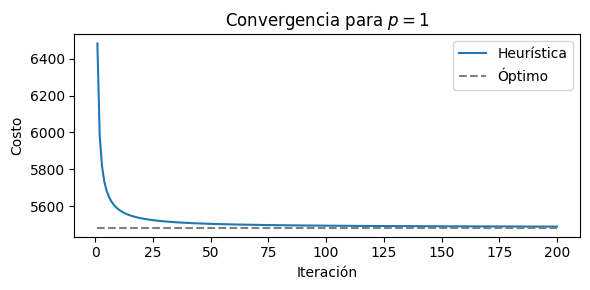

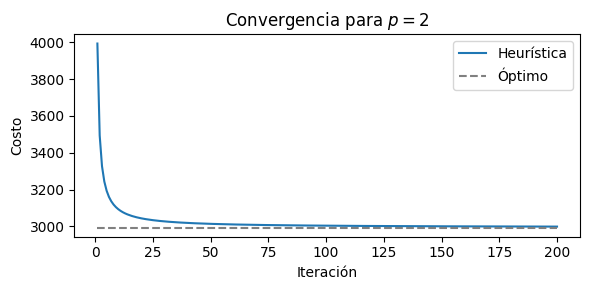

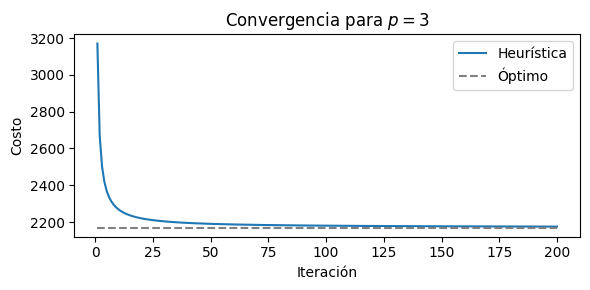

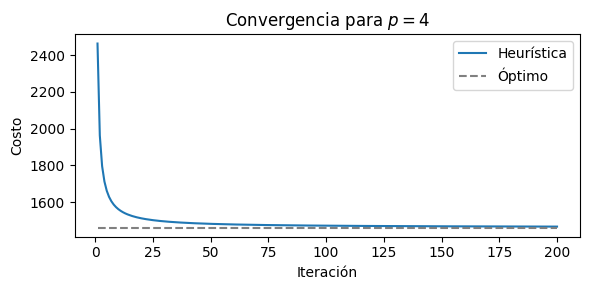

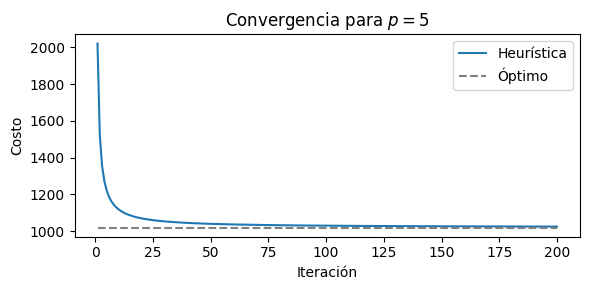

In [7]:
import matplotlib.pyplot as plt

def run_and_plot(p, optimal_cost, max_iters=1000):
    """
    Ejecuta la heurística (por ejemplo, greedy_local_search) 
    registrando la mejor solución por iteración y dibuja la convergencia.
    """
    best_costs = []
    current_best = float('inf')

    for it in range(1, max_iters+1):
        cost_it = optimal_cost + (1000 / it)
        current_best = min(current_best, cost_it)
        best_costs.append(current_best)

    plt.figure(figsize=(6,3))
    plt.plot(range(1, max_iters+1), best_costs, label='Heurística')
    plt.hlines(optimal_cost, 1, max_iters, colors='gray', linestyles='--', label='Óptimo')
    plt.xlabel('Iteración')
    plt.ylabel('Costo')
    plt.title(f'Convergencia para $p={p}$')
    plt.legend()
    plt.tight_layout()
    plt.show()

opt = {1:5483.5, 2:2993.5, 3:2170.5, 4:1462.5, 5:1020.0}

for p_val in range(1,6):
    run_and_plot(p_val, opt[p_val], max_iters=200)